In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ast
from collections import Counter

Let's see if the majority is always right !

In [57]:
# Load the data
finished_paths = pd.read_csv("data/clean_finished_paths.csv")

In [58]:
finished_paths.shape

(51249, 16)

In [59]:
finished_paths.describe()

,Unnamed: 0,timestamp,durationInSec,rating,nb_back_clicks,nb_clicks,path_length
count,51249.000000,5.124900e+04,51249.000000,51249.000000,51249.000000,51249.000000,51249.000000
mean,25634.648091,1.296390e+09,158.256044,0.816738,0.400398,5.757381,4.956585
std,14808.057694,4.935694e+07,360.793518,1.823400,1.450585,4.680603,3.289866
min,0.000000,1.219095e+09,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,12813.000000,1.250109e+09,60.000000,-1.000000,0.000000,4.000000,3.000000
50%,25629.000000,1.283896e+09,107.000000,1.000000,0.000000,5.000000,4.000000
75%,38441.000000,1.345233e+09,183.000000,2.000000,0.000000,7.000000,6.000000
max,51317.000000,1.389823e+09,35091.000000,5.000000,45.000000,434.000000,404.000000


In [60]:
finished_paths.columns

Index(['Unnamed: 0', 'hashedIpAddress', 'timestamp', 'durationInSec', 'path',
       'rating', 'nb_back_clicks', 'nb_clicks', 'path_length', 'source',
       'target', 'source_category', 'target_category',
       'source_general_category', 'target_general_category', 'clean_path'],
      dtype='object')

In [61]:
# Split the path into a list
finished_paths["path"] = finished_paths["path"].apply(lambda x: ast.literal_eval(x))

In [62]:
occ_all = Counter()
for p in finished_paths["path"]:
    occ_all += Counter(p)

In [63]:
occ_all.most_common(10)

[('<', 20520),
 ('United_States', 8890),
 ('Europe', 4359),
 ('United_Kingdom', 3901),
 ('England', 3332),
 ('Earth', 3219),
 ('Africa', 2795),
 ('World_War_II', 2299),
 ('North_America', 1869),
 ('Germany', 1768)]

In [64]:
occ_dest = Counter([p[-1] for p in finished_paths["path"]])

In [65]:
# We will try as 
occ_dest.most_common(10)

[('Telephone', 1134),
 ('Viking', 1071),
 ('Zebra', 955),
 ('Bean', 673),
 ('Adolf_Hitler', 600),
 ('Sun', 201),
 ('God', 200),
 ('Wood', 185),
 ('Great_white_shark', 184),
 ('Jesus', 182)]

In [133]:
def clean_path(path: list) -> list:
    """Clean a path from back clicks."""
    clean_path = []
    count = 0
    for element in path[::-1]:
        if element == "<":
            count += 1
            continue
        if count > 0:
            count -= 1
            continue
        clean_path.append(element)
    return clean_path[::-1]

In [134]:
# A simple len computation would not give us the right length for a path as you have to take into account the backbutton clicked
# and not taking into account the first page as the player do not choose it
def path_length(list):
    return len(clean_path(list)) - 1

In [66]:
def find_target(target, list):
    # Find the target and its successor
    ret = ''
    for i in range(len(list) - 1):  # Stop before the last element
        if list[i] == target:
            ret = list[i+1]
    return ret

In [67]:
def find_next(source, dest, df):
    paths_src = df[df['path'].apply(lambda x: source in x and x[-1]==dest)]['path']
    next_list = [find_target(source, path) for path in paths_src]
    next_list = [elem for elem in next_list if elem != '']
    number_of_votes = len(next_list)
    if number_of_votes==0:
        return number_of_votes, '' 
    else:
        return number_of_votes, Counter(next_list).most_common(1)[0][0]


In [68]:
find_next('North_America', 'Telephone', finished_paths)

(14, 'United_States')

In [69]:
find_next('Computer', 'Telephone', finished_paths)

(135, 'Telephone')

In [70]:
# Implement the actual crowd model where every players vote at each step
def crowd(src, dest, df):
    next = src
    path = [src]
    lst_votes = []
    while(next != dest):
        nb_votes, next = find_next(next, dest, df)
        lst_votes.append(nb_votes)
        if not(next in path) and nb_votes!=0:
            path.append(next)
        else:
            break
    return path, np.array(lst_votes)

In [71]:
# Let's find the most played paths
occ_path = Counter([(p[0], p[-1]) for p in finished_paths["path"]])
occ_path.most_common(10)

[(('Asteroid', 'Viking'), 1043),
 (('Brain', 'Telephone'), 1040),
 (('Theatre', 'Zebra'), 905),
 (('Pyramid', 'Bean'), 642),
 (('Batman', 'Wood'), 148),
 (('Bird', 'Great_white_shark'), 138),
 (('Batman', 'The_Holocaust'), 119),
 (('Bird', 'Adolf_Hitler'), 107),
 (('Beer', 'Sun'), 99),
 (('Batman', 'Banana'), 69)]

We have 4 paths that are way more present than others (10x), let's try these paths to see if we have a lot of votes

In [72]:
# Let's run the crowd model on the top 4 most played games
res_crowd_top4 = []
for ((src, dst), _) in occ_path.most_common(4):
    path, votes = crowd(src, dst, finished_paths)
    if (np.all(votes > 0)):
        res_crowd_top4.append(((src, dst), len(path)))
res_crowd_top4

[(('Asteroid', 'Viking'), 5),
 (('Brain', 'Telephone'), 5),
 (('Theatre', 'Zebra'), 4),
 (('Pyramid', 'Bean'), 6)]

In [73]:
# Let's see how well did actual players perform
avg_res_top4 = []
for ((src, dst), _) in occ_path.most_common(4):
    paths = finished_paths[finished_paths['path'].apply(lambda x: x[0]==src and x[-1]==dst)]['path']
    if len(paths)>0:
        avg_res_top4.append(((src, dst), paths.apply(lambda p: len(p)).sum()/len(paths))) 
avg_res_top4

[(('Asteroid', 'Viking'), 7.516778523489933),
 (('Brain', 'Telephone'), 7.1),
 (('Theatre', 'Zebra'), 7.83646408839779),
 (('Pyramid', 'Bean'), 8.246105919003115)]

In [74]:
# For the next analysis, it will be convenient to have functions to compute stats for any list of games
def stats_crowd(games):
    res_crowd = []
    for (src, dst) in games:
        path, votes = crowd(src, dst, finished_paths)
        if (np.all(votes > 0)):
            res_crowd.append(((src, dst), len(path)))
    return res_crowd

def stats_players(games):
    avg_res = []
    for (src, dst) in games:
        paths = finished_paths[finished_paths['path'].apply(lambda x: x[0]==src and x[-1]==dst)]['path']
        if len(paths)>0:
            avg_res.append(((src, dst), paths.apply(lambda p: len(p)).sum()/len(paths)))
    return avg_res

In [75]:
# Let's now look for games with as much data as possible
# We first store every words appearing in any game 
words = set()
for p in finished_paths["path"]:
    words.update(p)

In [76]:
len(words)

4170

In [ ]:
# Combining the 4128 words as (src, dst) tuple is a computationnaly extensive operation + pretty useless as many words appear
# less than 200 times => they will never give a game played a lot. Let's focus on words with more than 200 occurences
popular_words = [element for element, count in occ_all.items() if count > 200]
len(popular_words)

309

In [ ]:
# We now compute a score for each tuple of different words
# We take the score to be the minimum of voters for each step of the crowd computing
# We think it is a fair metric as a big score attest without fail the path makes intervene a lot of players at each step
# It would not be the case if we took just the sum of the list of votes
scores = []
iter = 0
for w1 in popular_words:
    for w2 in popular_words:
        print(f'iter #{iter}/{len(popular_words)**2}')
        iter += 1
        if (w1 != w2):
            res_path, votes = crowd(w1, w2, finished_paths)
            if (np.all(votes > 0) and res_path[-1]==w2):
                scores.append(((w1, w2), np.min(votes)))

In [ ]:
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
sorted_scores

In [104]:
len(scores)

11964

In [105]:
games_to_play = [(src, dst) for ((src, dst), count) in sorted_scores if count > 50 and src != '<' and dst != '<']
len(games_to_play)

95

In [106]:
# Let's see how well does the crowd in this game
ans_crowd = []
for (src, dst) in games_to_play:
    ans_crowd.append(crowd(src, dst, finished_paths))

In [ ]:
ans_crowd

In [135]:
ans_stats = []
for (src, dst) in games_to_play:
    paths = finished_paths[finished_paths['path'].apply(lambda x: src in x and x[-1]==dst)]['path']
    # Find the index of the first occurrence of the target element
    paths_src = []
    for p in paths:
        start_index = p.index(src)
        paths_src.append(p[start_index:])
    if len(paths_src) == 0:
        ans_stats.append(-1)
    else:
        ans_stats.append(sum(path_length(p) for p in paths_src) / len(paths_src))

In [139]:
ans_stats = np.array(ans_stats)

In [140]:
crowd_stats = np.array(list(map(lambda x: path_length(x[0]), ans_crowd)))

In [141]:
crowd_stats.shape

(95,)

In [142]:
ans_stats.shape

(95,)

In [143]:
np.all(crowd_stats > 0)

True

In [144]:
print(ans_stats.shape)
print(crowd_stats.shape)

(95,)
(95,)


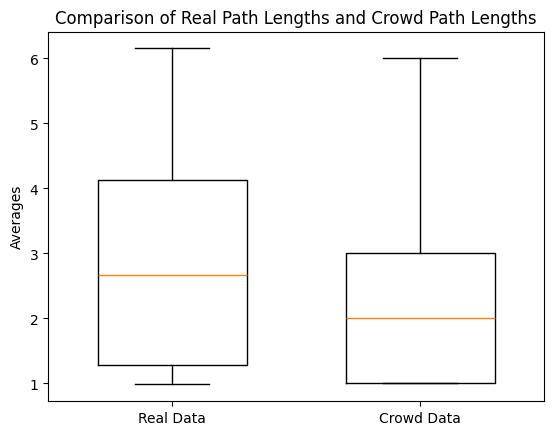

In [145]:
plt.boxplot([ans_stats, crowd_stats], positions=[1, 2], widths=0.6)
plt.xticks([1, 2], ['Real Data', 'Crowd Data'])
plt.title("Comparison of Real Path Lengths and Crowd Path Lengths")
plt.ylabel("Averages")
plt.show()

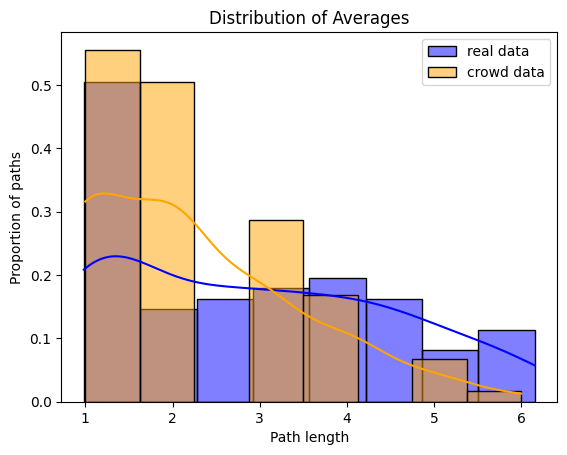

In [146]:
ax = sns.histplot(ans_stats, kde=True, stat='density', color='blue', label='real data')
ax = sns.histplot(crowd_stats, kde=True, stat='density', color='orange', label='crowd data')
ax.set(title='Distribution of Averages',xlabel='Path length', ylabel='Proportion of paths')
plt.legend()
plt.show()

Let's see for how many games, the crowd was right or had the same length

In [147]:
np.sum((ans_stats - crowd_stats) >= 0) / len(ans_stats)

0.9157894736842105

So 92% of time, the crowd was right.

In [148]:
import scipy.stats

# Let's compute a T-Test to see if the averages are significantly different, we choose a a paired t-test. 
# This test compares the means of two related groups
res = scipy.stats.ttest_rel(ans_stats, crowd_stats, alternative='less')
res.pvalue

0.9999999999999201

The null hypothesis (="the mean of the distribution underlying `ans_stats` is greater than the mean of the distribution underlying `crowd_stats`").\
P-value >> 0.05, this indicates that our observation is not so unlikely to have occurred by chance. \
Therefore, we do not reject the null hypothesis 